# Pipeline Architecture

1. **Dataset Structure & Multi-Class Setup**  
   The dataset is organized into multiple class subfolders (e.g., NORMAL, PNEUMONIA) under a main `dataset` folder, where each subfolder contains images for that particular class.

2. **GAN-Based Data Augmentation for Imbalance Handling**  
   For classes with fewer samples, a GAN is trained to generate synthetic images. This augmentation process is applied on a per-class basis to balance the training dataset.

3. **Generator Architecture in the GAN**  
   - **Input:** A latent vector (typically of dimension 100).  
   - **Structure:**  
     - A fully connected (`Linear`) layer projects and reshapes the latent vector into a 4D tensor.  
     - A series of upsampling blocks are applied; each block consists of an Upsample layer, a 2D convolution, batch normalization, and LeakyReLU activation.  
     - The final convolution outputs a 3-channel image and applies a Sigmoid activation to produce pixel values scaled between 0 and 1.
   - **Purpose:** To generate realistic synthetic images matching the input resolution for each class.

4. **Discriminator Architecture in the GAN**  
   - **Input:** Real or synthetic images.  
   - **Structure:**  
     - Multiple convolutional blocks use downsampling (with stride 2) along with LeakyReLU activations and dropout for regularization.  
     - The feature maps are then flattened and passed through a linear layer to output a single probability via a Sigmoid activation function.
   - **Purpose:** To distinguish between real and synthetic images, providing feedback to the generator during training.

5. **Training Strategy for the GAN**  
   - Uses Binary Cross-Entropy Loss for both generator and discriminator training.  
   - The discriminator receives smoothed labels (e.g., 0.9 for real images) to improve stability.  
   - Both networks are updated iteratively using the Adam optimizer with a specified learning rate and momentum parameters.

6. **Synthetic Data Generation & Integration**  
   - After training, the generator is used to create synthetic images equal to the difference between the maximum number of samples in any class and the current samples for the under-represented classes.  
   - These synthetic images are saved and then merged with the real training images to form an augmented balanced dataset.

7. **Classification Model – VGG16Enhanced**  
   - **Base:** Utilizes a pretrained VGG16 model as a fixed feature extractor (all convolutional features are frozen).  
   - **Enhancement:** Global Average Pooling is applied to reduce feature maps, followed by a custom classifier composed of several fully connected layers.
   
8. **Custom Classifier Details**  
   - **Layer Sequence:**  
     - The flattened output from global pooling is passed through a series of Linear layers (512 → 256 → 128 → 256 → 64 → `num_classes`) with ReLU activations and Dropout layers for regularization.  
     - This design allows the model to learn complex decision boundaries while mitigating overfitting.
   
9. **Training & Optimization of the Classifier**  
   - Uses CrossEntropyLoss with the Adam optimizer.  
   - A learning rate scheduler adapts the learning rate based on the validation loss, and the model with the best validation performance is saved for testing.
   
10. **Evaluation & Reporting**  
    - Performance is measured using accuracy, precision, recall, F1-score, and confusion matrices.  
    - The distribution of both real and synthetic data is visualized (e.g., using pie charts), and training/validation accuracy and loss curves are plotted to assess convergence.



In [1]:
!git clone https://github.com/Sunnyanai-alt/chest-x-ray-deep-learning-project.git

Cloning into 'chest-x-ray-deep-learning-project'...
remote: Enumerating objects: 5856, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 5856 (delta 1), reused 0 (delta 0), pack-reused 5842 (from 2)
Receiving objects: 100% (5856/5856), 1.13 GiB | 15.18 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (5867/5867), done.


In [2]:
data_path = "/content/chest-x-ray-deep-learning-project/dataset"

### Libraries Import

In [3]:
import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Augmentation using GAN (handle data imbalance)

In [4]:
class SingleClassDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.paths = [
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.lower().endswith(('.png','jpg','jpeg'))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.init_size = 14
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 256 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128,  64, 3, padding=1), nn.BatchNorm2d(64),  nn.LeakyReLU(0.2, True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64,   32, 3, padding=1), nn.BatchNorm2d(32),  nn.LeakyReLU(0.2, True),
            nn.Conv2d(32,    3, 3, padding=1), nn.Sigmoid()  # [0,1] output
        )

    def forward(self, z):
        out = self.l1(z).view(z.size(0), 256, self.init_size, self.init_size)
        return self.conv_blocks(out)

class Discriminator(nn.Module):
    def __init__(self, img_size=224):
        super().__init__()
        def cb(in_c, out_c):
            return [
                nn.Conv2d(in_c, out_c, 3, stride=2, padding=1),
                nn.LeakyReLU(0.2, True),
                nn.Dropout(0.4)
            ]
        self.model = nn.Sequential(
            *cb(3,  64),   # 224→112
            *cb(64, 128),  # 112→56
            *cb(128,256),  # 56→28
            nn.Flatten(),
            nn.Linear(256*(img_size//8)*(img_size//8), 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

def train_dcgan(gen, disc, loader, latent_dim, device,
                epochs=200, lr=2e-4, beta1=0.5):
    criterion = nn.BCELoss()
    opt_d = optim.Adam(disc.parameters(), lr=lr, betas=(beta1,0.999))
    opt_g = optim.Adam(gen.parameters(),  lr=lr, betas=(beta1,0.999))
    gen.to(device); disc.to(device)

    for epoch in range(1, epochs+1):
        d_loss_acc, g_loss_acc = 0, 0
        for real in loader:  # num_workers=0 to avoid Windows crashes
            bs = real.size(0)
            real = real.to(device)
            # smoothed real labels=0.9, fake=0
            real_lbl = torch.full((bs,1), 0.9, device=device)
            fake_lbl = torch.zeros((bs,1), device=device)

            # Discriminator step
            disc.zero_grad()
            out_real = disc(real)
            d_real = criterion(out_real, real_lbl)
            z = torch.randn(bs, latent_dim, device=device)
            fake = gen(z)
            out_fake = disc(fake.detach())
            d_fake = criterion(out_fake, fake_lbl)
            (d_real + d_fake).backward()
            opt_d.step()

            # Generator step
            gen.zero_grad()
            valid_lbl = torch.ones((bs,1), device=device)
            out = disc(fake)
            g_loss = criterion(out, valid_lbl)
            g_loss.backward()
            opt_g.step()

            d_loss_acc += (d_real + d_fake).item()
            g_loss_acc += g_loss.item()

        print(f"Epoch {epoch}/{epochs} | D_loss: {d_loss_acc/len(loader):.4f} | G_loss: {g_loss_acc/len(loader):.4f}")

    return gen


data_root      = "/content/chest-x-ray-deep-learning-project/dataset/train"
synthetic_root = "synthetic"
os.makedirs(synthetic_root, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root,d))]
orig_counts = {}
for cls in classes:
    folder = os.path.join(data_root, cls)
    imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.png','jpg','jpeg'))]
    orig_counts[cls] = len(imgs)
max_count = max(orig_counts.values())
print("Original counts:", orig_counts)

gan_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
latent_dim = 100
epochs     = 50
batch_size = 64

synthetic_counts = {}
for cls, cnt in orig_counts.items():
    need = max_count - cnt
    synthetic_counts[cls] = 0
    if need <= 0:
        print(f"[{cls}] has {cnt}, no synthetic needed.")
        continue

    print(f"[{cls}] needs {need} synthetic images → training GAN…")
    # prepare data loader
    ds     = SingleClassDataset(os.path.join(data_root,cls), transform=gan_transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0)

    # build & train
    gen  = Generator(latent_dim).to(device)
    disc = Discriminator().to(device)
    gen  = train_dcgan(gen, disc, loader, latent_dim, device,
                        epochs=epochs)

    # generate & save
    out_dir = os.path.join(synthetic_root, cls)
    os.makedirs(out_dir, exist_ok=True)
    for i in tqdm(range(need), desc=f"Generating [{cls}]"):
        z = torch.randn(1, latent_dim, device=device)
        with torch.no_grad():
            fake = gen(z).cpu().squeeze(0)
        pil = transforms.ToPILImage()(fake)
        pil.save(os.path.join(out_dir, f"synthetic_{i}.png"))
        synthetic_counts[cls] += 1

# 4c) Report final counts
total_counts = {cls: orig_counts[cls] + synthetic_counts.get(cls,0) for cls in classes}
print("Synthetic counts:", synthetic_counts)
print("Total counts after augmentation:", total_counts)

Original counts: {'NORMAL': 1341, 'PNEUMONIA': 3875}
[NORMAL] needs 2534 synthetic images → training GAN…
Epoch 1/50 | D_loss: 1.1271 | G_loss: 1.5253
Epoch 2/50 | D_loss: 1.3089 | G_loss: 0.9710
Epoch 3/50 | D_loss: 1.3381 | G_loss: 0.9093
Epoch 4/50 | D_loss: 1.3564 | G_loss: 0.8893
Epoch 5/50 | D_loss: 1.3624 | G_loss: 0.8505
Epoch 6/50 | D_loss: 1.3922 | G_loss: 0.9151
Epoch 7/50 | D_loss: 1.3575 | G_loss: 0.8592
Epoch 8/50 | D_loss: 1.3416 | G_loss: 0.8514
Epoch 9/50 | D_loss: 1.3241 | G_loss: 0.9290
Epoch 10/50 | D_loss: 1.3439 | G_loss: 0.8765
Epoch 11/50 | D_loss: 1.3583 | G_loss: 0.9199
Epoch 12/50 | D_loss: 1.3551 | G_loss: 0.8785
Epoch 13/50 | D_loss: 1.3561 | G_loss: 0.8516
Epoch 14/50 | D_loss: 1.3535 | G_loss: 0.8423
Epoch 15/50 | D_loss: 1.3529 | G_loss: 0.8396
Epoch 16/50 | D_loss: 1.3568 | G_loss: 0.8495
Epoch 17/50 | D_loss: 1.3424 | G_loss: 0.8808
Epoch 18/50 | D_loss: 1.3334 | G_loss: 0.8662
Epoch 19/50 | D_loss: 1.3448 | G_loss: 0.8646
Epoch 20/50 | D_loss: 1.3425 

Generating [NORMAL]: 100%|██████████| 2534/2534 [01:10<00:00, 35.87it/s]

[PNEUMONIA] has 3875, no synthetic needed.
Synthetic counts: {'NORMAL': 2534, 'PNEUMONIA': 0}
Total counts after augmentation: {'NORMAL': 3875, 'PNEUMONIA': 3875}


In [5]:
# Hyperparameters
batch_size = 64
num_epochs = 30
lr = 1e-3
num_classes = 2

# Data Transforms
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset loading
real_train_ds = datasets.ImageFolder("/content/chest-x-ray-deep-learning-project/dataset/train", transform=basic_transform)
synthetic_ds = datasets.ImageFolder("/content/synthetic", transform=basic_transform)
synthetic_ds.classes = real_train_ds.classes
synthetic_ds.class_to_idx = real_train_ds.class_to_idx

train_ds = ConcatDataset([real_train_ds, synthetic_ds])
val_ds = datasets.ImageFolder("/content/chest-x-ray-deep-learning-project/dataset/val", transform=basic_transform)
test_ds = datasets.ImageFolder("/content/chest-x-ray-deep-learning-project/dataset/test", transform=basic_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

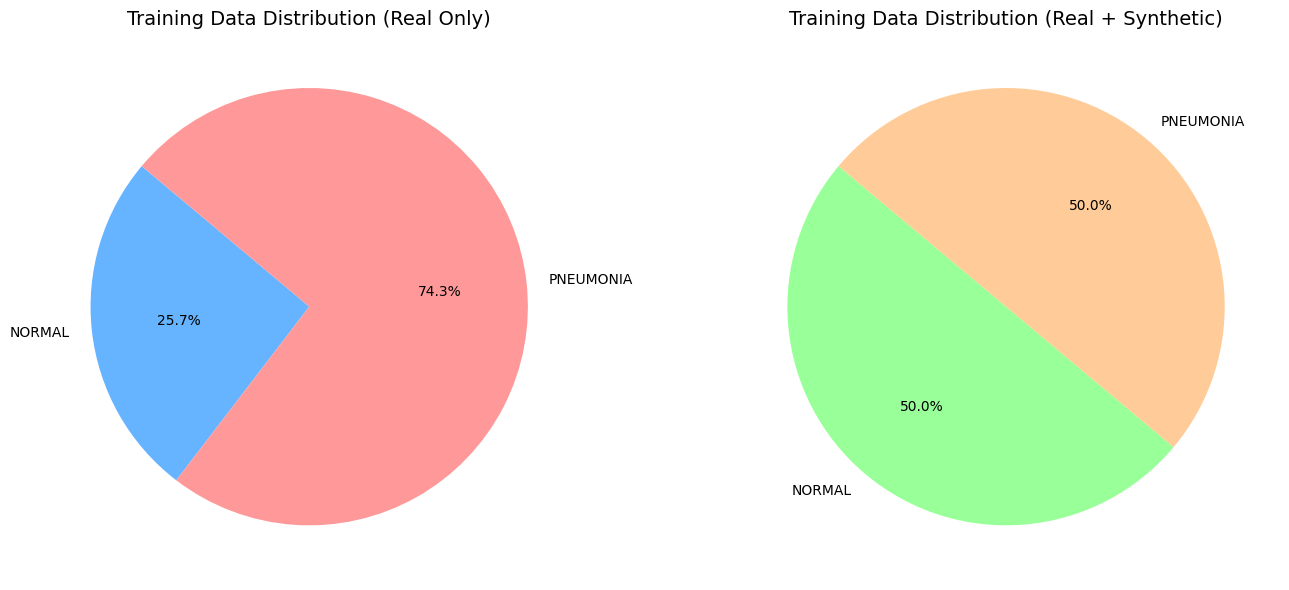

In [6]:
# Count real training data
real_counts = Counter([real_train_ds.targets[i] for i in range(len(real_train_ds))])
real_labels = [real_train_ds.classes[i] for i in real_counts.keys()]
real_sizes = list(real_counts.values())

# Count combined (real + synthetic) data
combined_targets = [real_train_ds.targets[i] for i in range(len(real_train_ds))] + \
                   [synthetic_ds.targets[i] for i in range(len(synthetic_ds))]
combined_counts = Counter(combined_targets)
combined_labels = [real_train_ds.classes[i] for i in combined_counts.keys()]
combined_sizes = list(combined_counts.values())

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real data pie
axes[0].pie(real_sizes, labels=real_labels, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
axes[0].set_title('Training Data Distribution (Real Only)', fontsize=14)

# Combined data pie
axes[1].pie(combined_sizes, labels=combined_labels, autopct='%1.1f%%', startangle=140, colors=['#99ff99','#ffcc99'])
axes[1].set_title('Training Data Distribution (Real + Synthetic)', fontsize=14)

plt.tight_layout()
plt.show()

### VGG and Neural Network

In [7]:
# Custom Model
class VGG16Enhanced(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Enhanced, self).__init__()
        base_model = models.vgg16(pretrained=True)
        for param in base_model.features.parameters():
            param.requires_grad = False

        self.features = base_model.features
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

In [8]:
# Model, Loss, Optimizer, Scheduler
model = VGG16Enhanced(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=1e-6)

# Training and Validation Loop
train_acc_hist, val_acc_hist = [], []
train_loss_hist, val_loss_hist = [], []
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load best model
model.load_state_dict(torch.load("best_model.pth"))

# Test Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.numpy())


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 155MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
[Epoch 1/30] 

Epoch 1/30 -> Train Loss: 0.1751, Val Loss: 0.1202 | Train Acc: 0.9245, Val Acc: 1.0000


[Epoch 2/30] Training: 100%|██████████| 122/122 [02:18<00:00,  1.13s/it]


Epoch 2/30 -> Train Loss: 0.0801, Val Loss: 0.2728 | Train Acc: 0.9721, Val Acc: 0.8750


[Epoch 3/30] Training: 100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 3/30 -> Train Loss: 0.0618, Val Loss: 0.0928 | Train Acc: 0.9782, Val Acc: 1.0000


[Epoch 4/30] Training: 100%|██████████| 122/122 [02:24<00:00,  1.18s/it]


Epoch 4/30 -> Train Loss: 0.0535, Val Loss: 0.1641 | Train Acc: 0.9799, Val Acc: 1.0000


[Epoch 5/30] Training: 100%|██████████| 122/122 [02:19<00:00,  1.14s/it]


Epoch 5/30 -> Train Loss: 0.0493, Val Loss: 0.0132 | Train Acc: 0.9821, Val Acc: 1.0000


[Epoch 6/30] Training: 100%|██████████| 122/122 [02:18<00:00,  1.14s/it]


Epoch 6/30 -> Train Loss: 0.0501, Val Loss: 0.0260 | Train Acc: 0.9823, Val Acc: 1.0000


[Epoch 7/30] Training: 100%|██████████| 122/122 [02:17<00:00,  1.12s/it]


Epoch 7/30 -> Train Loss: 0.0535, Val Loss: 0.1439 | Train Acc: 0.9806, Val Acc: 0.9375


[Epoch 8/30] Training: 100%|██████████| 122/122 [02:17<00:00,  1.12s/it]


Epoch 8/30 -> Train Loss: 0.0435, Val Loss: 0.0186 | Train Acc: 0.9832, Val Acc: 1.0000


[Epoch 9/30] Training: 100%|██████████| 122/122 [02:17<00:00,  1.13s/it]


Epoch 9/30 -> Train Loss: 0.0405, Val Loss: 0.0882 | Train Acc: 0.9852, Val Acc: 1.0000


[Epoch 10/30] Training: 100%|██████████| 122/122 [02:16<00:00,  1.12s/it]


Epoch 10/30 -> Train Loss: 0.0356, Val Loss: 0.0881 | Train Acc: 0.9871, Val Acc: 1.0000


[Epoch 11/30] Training: 100%|██████████| 122/122 [02:19<00:00,  1.14s/it]


Epoch 11/30 -> Train Loss: 0.0338, Val Loss: 0.1333 | Train Acc: 0.9857, Val Acc: 0.9375


[Epoch 12/30] Training: 100%|██████████| 122/122 [02:19<00:00,  1.15s/it]


Epoch 12/30 -> Train Loss: 0.0294, Val Loss: 0.1027 | Train Acc: 0.9883, Val Acc: 0.9375


[Epoch 13/30] Training: 100%|██████████| 122/122 [02:20<00:00,  1.15s/it]


Epoch 13/30 -> Train Loss: 0.0292, Val Loss: 0.0479 | Train Acc: 0.9884, Val Acc: 1.0000


[Epoch 14/30] Training: 100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 14/30 -> Train Loss: 0.0267, Val Loss: 0.1130 | Train Acc: 0.9903, Val Acc: 0.9375


[Epoch 15/30] Training: 100%|██████████| 122/122 [02:19<00:00,  1.14s/it]


Epoch 15/30 -> Train Loss: 0.0232, Val Loss: 0.0763 | Train Acc: 0.9897, Val Acc: 0.9375


[Epoch 16/30] Training: 100%|██████████| 122/122 [02:21<00:00,  1.16s/it]


Epoch 16/30 -> Train Loss: 0.0214, Val Loss: 0.0799 | Train Acc: 0.9917, Val Acc: 0.9375


[Epoch 17/30] Training: 100%|██████████| 122/122 [02:16<00:00,  1.12s/it]


Epoch 17/30 -> Train Loss: 0.0196, Val Loss: 0.0915 | Train Acc: 0.9928, Val Acc: 0.9375


[Epoch 18/30] Training: 100%|██████████| 122/122 [02:18<00:00,  1.14s/it]


Epoch 18/30 -> Train Loss: 0.0175, Val Loss: 0.1003 | Train Acc: 0.9928, Val Acc: 0.9375


[Epoch 19/30] Training: 100%|██████████| 122/122 [02:17<00:00,  1.13s/it]


Epoch 19/30 -> Train Loss: 0.0156, Val Loss: 0.0826 | Train Acc: 0.9941, Val Acc: 0.9375


[Epoch 20/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 20/30 -> Train Loss: 0.0168, Val Loss: 0.1036 | Train Acc: 0.9934, Val Acc: 0.9375


[Epoch 21/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 21/30 -> Train Loss: 0.0164, Val Loss: 0.1148 | Train Acc: 0.9939, Val Acc: 0.9375


[Epoch 22/30] Training: 100%|██████████| 122/122 [02:16<00:00,  1.12s/it]


Epoch 22/30 -> Train Loss: 0.0139, Val Loss: 0.1837 | Train Acc: 0.9948, Val Acc: 0.9375


[Epoch 23/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 23/30 -> Train Loss: 0.0126, Val Loss: 0.0920 | Train Acc: 0.9957, Val Acc: 0.9375


[Epoch 24/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 24/30 -> Train Loss: 0.0151, Val Loss: 0.1930 | Train Acc: 0.9955, Val Acc: 0.9375


[Epoch 25/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 25/30 -> Train Loss: 0.0128, Val Loss: 0.1458 | Train Acc: 0.9955, Val Acc: 0.9375


[Epoch 26/30] Training: 100%|██████████| 122/122 [02:18<00:00,  1.13s/it]


Epoch 26/30 -> Train Loss: 0.0116, Val Loss: 0.1589 | Train Acc: 0.9964, Val Acc: 0.9375


[Epoch 27/30] Training: 100%|██████████| 122/122 [02:14<00:00,  1.11s/it]


Epoch 27/30 -> Train Loss: 0.0109, Val Loss: 0.1568 | Train Acc: 0.9954, Val Acc: 0.9375


[Epoch 28/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 28/30 -> Train Loss: 0.0102, Val Loss: 0.1603 | Train Acc: 0.9966, Val Acc: 0.9375


[Epoch 29/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 29/30 -> Train Loss: 0.0102, Val Loss: 0.1917 | Train Acc: 0.9966, Val Acc: 0.9375


[Epoch 30/30] Training: 100%|██████████| 122/122 [02:15<00:00,  1.11s/it]


Epoch 30/30 -> Train Loss: 0.0090, Val Loss: 0.1786 | Train Acc: 0.9968, Val Acc: 0.9375


### Evaluation

In [9]:
# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=real_train_ds.classes))
print(f"Test Accuracy:  {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1 Score:       {f1:.4f}")


--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.89      0.80      0.84       234
   PNEUMONIA       0.89      0.94      0.91       390

    accuracy                           0.89       624
   macro avg       0.89      0.87      0.88       624
weighted avg       0.89      0.89      0.89       624

Test Accuracy:  0.8894
Precision:      0.8907
Recall:         0.8714
F1 Score:       0.8793


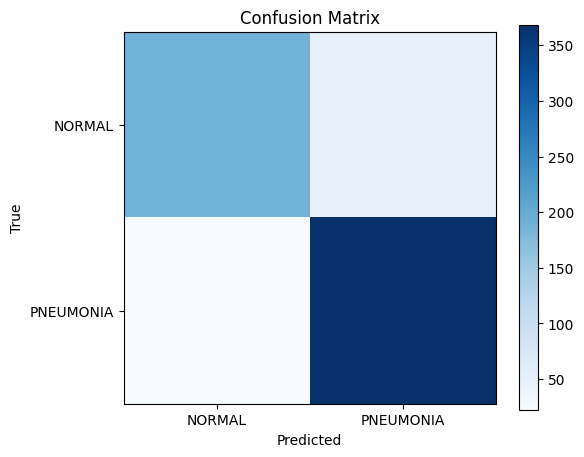

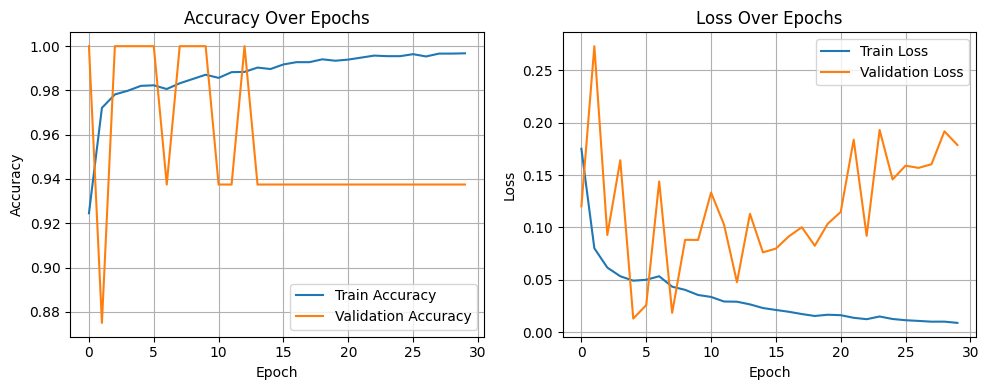

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(num_classes), real_train_ds.classes)
plt.yticks(np.arange(num_classes), real_train_ds.classes)
plt.colorbar()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Prediction

In [11]:
import torch
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import os

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Same transforms as training ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Class mapping (update this as per your actual class names) ---
class_names = ['Normal', 'Pneumonia']  # example

# --- Define the model architecture ---
class VGG16Enhanced(nn.Module):
    def __init__(self, num_classes):
        super(VGG16Enhanced, self).__init__()
        base_model = models.vgg16(pretrained=True)
        for param in base_model.features.parameters():
            param.requires_grad = False

        self.features = base_model.features
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

# --- Load model ---
model = VGG16Enhanced(num_classes=2)  # Update if you have more classes
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

# --- Prediction Function ---
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()
        class_name = class_names[class_index]

    print(f"Predicted class: {class_name}")
    return class_name

# test_image_path = "dataset/train/PNEUMONIA/person1_bacteria_2.jpeg"
test_image_path = "/content/chest-x-ray-deep-learning-project/dataset/train/NORMAL/IM-0115-0001.jpeg"

predict_image(test_image_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted class: Normal


'Normal'